In [1]:
import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
import sagemaker

In [2]:
!pip install xgboost

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import data_manipulation as dm
import xgboost as xgb

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


## Setting up session

In [4]:
sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()

region = sess.boto_session.region_name
bucket = 'lvp-ion-switching'

print('Using bucket ' + bucket)

Using bucket lvp-ion-switching


## Loading Data

In [5]:
train_name = "train_clean.csv"
test_name = "test_clean.csv"

train_path = f's3://{bucket}/{train_name}'
test_path = f's3://{bucket}/{test_name}'

all_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

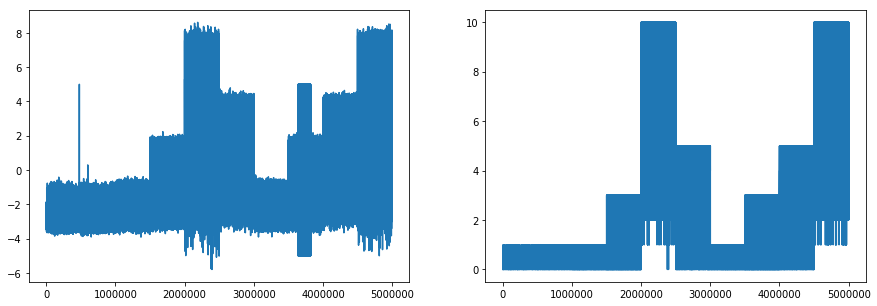

In [6]:
dm.plot_signal_and_channels(all_data)

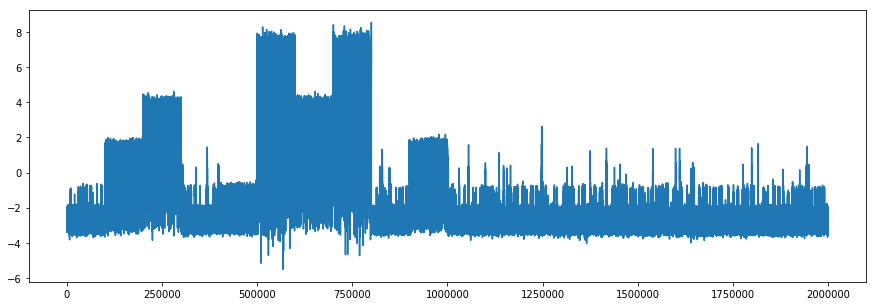

In [7]:
dm.plot_signal(test_data)

## Feature engineering
Here we are adding the shifted version of the signal variable as feature, with the shift ranging from -9 to +9. As demonstrated in the RandomForest notebook, this results in a much better prediction.

In [8]:
dm.load_shifted_values([all_data, test_data], max_shift=10)

In [9]:
all_data.head()

,time,signal,open_channels,previous_signal_1,next_signal_1,previous_signal_2,next_signal_2,previous_signal_3,next_signal_3,previous_signal_4,...,previous_signal_5,next_signal_5,previous_signal_6,next_signal_6,previous_signal_7,next_signal_7,previous_signal_8,next_signal_8,previous_signal_9,next_signal_9
0,0.0001,-2.7600,0,-2.7600,-2.8557,-2.7600,-2.4074,-2.7600,-3.1404,-2.76,...,-2.76,-2.6418,-2.76,-2.6993,-2.76,-2.5935,-2.76,-2.6682,-2.76,-2.7586
1,0.0002,-2.8557,0,-2.7600,-2.4074,-2.7600,-3.1404,-2.7600,-3.1525,-2.76,...,-2.76,-2.6993,-2.76,-2.5935,-2.76,-2.6682,-2.76,-2.7586,-2.76,-3.1136
2,0.0003,-2.4074,0,-2.8557,-3.1404,-2.7600,-3.1525,-2.7600,-2.6418,-2.76,...,-2.76,-2.5935,-2.76,-2.6682,-2.76,-2.7586,-2.76,-3.1136,-2.76,-2.6221
3,0.0004,-3.1404,0,-2.4074,-3.1525,-2.8557,-2.6418,-2.7600,-2.6993,-2.76,...,-2.76,-2.6682,-2.76,-2.7586,-2.76,-3.1136,-2.76,-2.6221,-2.76,-2.7316
4,0.0005,-3.1525,0,-3.1404,-2.6418,-2.4074,-2.6993,-2.8557,-2.5935,-2.76,...,-2.76,-2.7586,-2.76,-3.1136,-2.76,-2.6221,-2.76,-2.7316,-2.76,-2.9028


In [10]:
test_data.head()

,time,signal,previous_signal_1,next_signal_1,previous_signal_2,next_signal_2,previous_signal_3,next_signal_3,previous_signal_4,next_signal_4,previous_signal_5,next_signal_5,previous_signal_6,next_signal_6,previous_signal_7,next_signal_7,previous_signal_8,next_signal_8,previous_signal_9,next_signal_9
0,500.0001,-2.649831,-2.649831,-2.849463,-2.649831,-2.860094,-2.649831,-2.435126,-2.649831,-2.615657,-2.649831,-2.566088,-2.649831,-2.738020,-2.649831,-2.779051,-2.649831,-2.848083,-2.649831,-2.376114
1,500.0002,-2.849463,-2.649831,-2.860094,-2.649831,-2.435126,-2.649831,-2.615657,-2.649831,-2.566088,-2.649831,-2.738020,-2.649831,-2.779051,-2.649831,-2.848083,-2.649831,-2.376114,-2.649831,-2.938646
2,500.0003,-2.860094,-2.849463,-2.435126,-2.649831,-2.615657,-2.649831,-2.566088,-2.649831,-2.738020,-2.649831,-2.779051,-2.649831,-2.848083,-2.649831,-2.376114,-2.649831,-2.938646,-2.649831,-2.622077
3,500.0004,-2.435126,-2.860094,-2.615657,-2.849463,-2.566088,-2.649831,-2.738020,-2.649831,-2.779051,-2.649831,-2.848083,-2.649831,-2.376114,-2.649831,-2.938646,-2.649831,-2.622077,-2.649831,-2.912308
4,500.0005,-2.615657,-2.435126,-2.566088,-2.860094,-2.738020,-2.849463,-2.779051,-2.649831,-2.848083,-2.649831,-2.376114,-2.649831,-2.938646,-2.649831,-2.622077,-2.649831,-2.912308,-2.649831,-3.125440


### Index feature for training data
This new feature indicates the number of the chunk of 50k samples to which each sample belongs. Since the original data was generated by chunks which were then concatenated, this is helpful for prediction as demonstrated in the RandomForest notebook.

In [12]:
def get_index_mod_int(col, d):
    return pd.Series(range(len(col))).floordiv(d)

index_feat = get_index_mod_int(all_data['time'], 50000)
all_data['index_feat'] = index_feat
train_data = all_data.drop(columns=['time', 'open_channels'])

### Index feature for test data
For the corresponding feature in the test data, we compute for each 50k chunk of the test data, which 50k chunk of the train data is the closest (by computing the distance induced by the canonical dot product)

In [14]:
def compute_closest_chunk(training_df, vec):
    chunk_size = len(vec)
    nb_chunks = len(training_df) // chunk_size
    min_dist = 1e100
    min_chunk_idx = -1
    for i in range(nb_chunks):
        new_dist = np.sum((vec - training_df['signal'].iloc[i*chunk_size:(i+1)*chunk_size].values)**2)
        if new_dist < min_dist:
            min_dist = new_dist
            min_chunk_idx = i
    return min_chunk_idx

test_data['index_feat'] = np.zeros(len(test_data))
chunk_size = 50000
nb_chunks = len(test_data) // chunk_size
for i in range(nb_chunks):
    test_data['index_feat'].iloc[i*chunk_size:(i+1)*chunk_size] = compute_closest_chunk(train_data, test_data['signal'].iloc[i*chunk_size:(i+1)*chunk_size])

In [15]:
test_data.columns

Index(['time', 'signal', 'previous_signal_1', 'next_signal_1',
       'previous_signal_2', 'next_signal_2', 'previous_signal_3',
       'next_signal_3', 'previous_signal_4', 'next_signal_4',
       'previous_signal_5', 'next_signal_5', 'previous_signal_6',
       'next_signal_6', 'previous_signal_7', 'next_signal_7',
       'previous_signal_8', 'next_signal_8', 'previous_signal_9',
       'next_signal_9', 'index_feat'],
      dtype='object')

In [16]:
train_data.columns

Index(['signal', 'previous_signal_1', 'next_signal_1', 'previous_signal_2',
       'next_signal_2', 'previous_signal_3', 'next_signal_3',
       'previous_signal_4', 'next_signal_4', 'previous_signal_5',
       'next_signal_5', 'previous_signal_6', 'next_signal_6',
       'previous_signal_7', 'next_signal_7', 'previous_signal_8',
       'next_signal_8', 'previous_signal_9', 'next_signal_9', 'index_feat'],
      dtype='object')